2
training started ...
episode: 0: reward: -200.00, mean_100: -200.00, epsilon: 0.40
training started ...
episode: 1: reward: -200.00, mean_100: -200.00, epsilon: 0.40
training started ...
episode: 2: reward: -200.00, mean_100: -200.00, epsilon: 0.40
training started ...
episode: 3: reward: -200.00, mean_100: -200.00, epsilon: 0.40
training started ...
episode: 4: reward: -200.00, mean_100: -200.00, epsilon: 0.40
training started ...
episode: 5: reward: -200.00, mean_100: -200.00, epsilon: 0.40
training started ...
episode: 6: reward: -200.00, mean_100: -200.00, epsilon: 0.40
training started ...
episode: 7: reward: -200.00, mean_100: -200.00, epsilon: 0.39
training started ...
episode: 8: reward: -200.00, mean_100: -200.00, epsilon: 0.39
training started ...
episode: 9: reward: -200.00, mean_100: -200.00, epsilon: 0.39
training started ...
episode: 10: reward: -200.00, mean_100: -200.00, epsilon: 0.39
training started ...
episode: 11: reward: -200.00, mean_100: -200.00, epsilon: 0.39


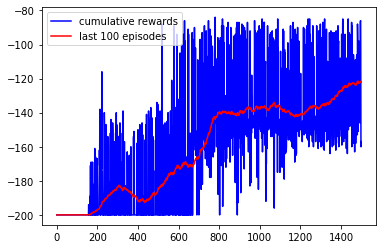

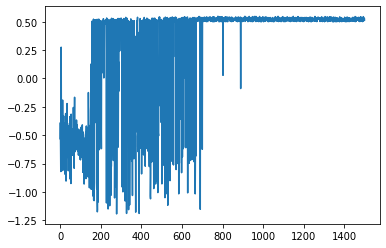

Complete


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import random
from collections import namedtuple

import warnings
#warnings.simplefilter("error")
warnings.simplefilter("ignore", UserWarning)

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

TARGET_UPDATE = 5
num_episodes = 1500
hidden = 100
gamma = 0.99
replay_buffer_size = 1000000
batch_size = 25
eps_stop = 0.1
epsilon = 0.5
eps = 0.4
Start_epsilon_decaying=0
End_epsilon_decaying=num_episodes//2
epsilon_decaying= epsilon/(End_epsilon_decaying-Start_epsilon_decaying)


class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):
    def __init__(self, state_space_dim, action_space_dim, hidden):
        super(DQN, self).__init__()
        self.hidden = hidden
        self.fc1 = nn.Linear(state_space_dim, hidden)
        #self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, action_space_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, p=0.3)
        #x = F.relu(x)
        #x = self.fc2(x)
        #x = F.relu(x)
        x = self.fc3(x)
        return x


class DQNAgent(object):
    def __init__(self, state_space, n_actions, replay_buffer_size,
                 batch_size, hidden_size, gamma):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.n_actions = n_actions
        self.state_space_dim = state_space
        self.policy_net = DQN(state_space, n_actions, hidden_size).to(self.device)
        self.target_net = DQN(state_space, n_actions, hidden_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-3)
        self.memory = ReplayMemory(replay_buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma

    def update_network(self, updates=1):
        for _ in range(updates):
            self._do_network_update()

    def _do_network_update(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = 1 - torch.tensor(batch.done, dtype=torch.uint8)
        non_final_next_states = [s for nonfinal, s in zip(non_final_mask,
                                                          batch.next_state) if nonfinal > 0]
        non_final_next_states = torch.stack(non_final_next_states).to(self.device)
        state_batch = torch.stack(batch.state).to(self.device)
        action_batch = torch.cat(batch.action).to(self.device)
        reward_batch = torch.cat(batch.reward).to(self.device)

        self.optimizer.zero_grad()
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(self.batch_size).to(self.device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values.squeeze(),
                                expected_state_action_values)

        # Optimize the model
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1e-1, 1e-1)
        self.optimizer.step()

    def get_action(self, state, epsilon):
        sample = random.random()
        if sample > epsilon:
            with torch.no_grad():
                state = torch.from_numpy(state).float().to(self.device)
                q_values = self.policy_net(state).to(self.device)
                return torch.argmax(q_values).item()
        else:
            return random.randrange(self.n_actions)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def store_transition(self, state, action, next_state, reward, done):
        action = torch.Tensor([[action]]).long()
        reward = torch.tensor([reward], dtype=torch.float32)
        next_state = torch.from_numpy(next_state).float()
        state = torch.from_numpy(state).float()
        self.memory.push(state, action, next_state, reward, done)

env = gym.make("MountainCar-v0")
env.reset()
n_actions = env.action_space.n
state_space_dim = env.observation_space.shape[0]
print(state_space_dim)
agent = DQNAgent(state_space_dim, n_actions, replay_buffer_size, batch_size,
                  hidden, gamma)

# Training loop
cumulative_rewards = []
counter_reach_goal = 0
last100_rewards = [-200 for _ in range(100) ] 
positions = []
for ep in range(num_episodes):
    # Initialize the environment and state
    print('training started ...')
    state = env.reset()
    done = False
    eps -= epsilon_decaying
    epsilon = max(0.05 , eps)
    cum_reward = 0
    
    while not done:
        #if ep % 100 == 0:
            #env.render()
        # Select and perform an action
        action = agent.get_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        cum_reward += reward

        agent.store_transition(state, action, next_state, reward, done)
        agent.update_network()

        # Move to the next state
        state = next_state

    positions.append(state[0])
    cumulative_rewards.append(cum_reward)
    if ep >= 100:
        last100_rewards.append(np.mean(cumulative_rewards[ep - 100:ep]))
    print("episode: %d: reward: %6.2f, mean_100: %6.2f, epsilon: %.2f" % (
        ep, cum_reward, np.mean(cumulative_rewards[-100:]), epsilon))

    if np.mean(cumulative_rewards[-100:]) > 195.0:
        print("Solved in ep : {} and break".format(ep))
        break

    # Update the target network, copying all weights and biases in DQN
    if ep % TARGET_UPDATE == 0:
        agent.update_target_network()
    
#env.close()
plt.plot(range(num_episodes),cumulative_rewards,label='cumulative rewards', color = 'b')
plt.plot(range(num_episodes),last100_rewards,label='last 100 episodes', color = 'r')
plt.legend(loc = 2)
plt.show()
plt.plot(range(num_episodes),positions)
plt.show()
print('Complete')